## Datasets

### Preparando o ambiente

In [13]:
import os
import json
import shutil
from tqdm.notebook import tqdm

import cv2
import timm
import hiera
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.optim import Adam

import random
import torchvision
from torchvision import transforms, datasets
from transformers import AlignProcessor, AlignModel
import pandas as pd
from torch.utils.data import random_split
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.cluster import KMeans

In [14]:
PROJECT_FOLDER = "/home/gabrielg/Workspace/transformer-vs-deeplearning"
DATASETS_PATH = f"{PROJECT_FOLDER}/Data"
BIRDS_PATH = f"{DATASETS_PATH}/BIRDS"

#### Baixando o Dataset BIRDS

Contém +- 200 imagens por Classe;
525 Classes;

https://www.kaggle.com/datasets/gpiosenka/100-bird-*species*

In [4]:
# with open(f"{DATASETS_PATH}/kaggle.json") as file:
#   kaggle_key = json.load(file)
# os.environ['KAGGLE_USERNAME'] = kaggle_key['username']
# os.environ['KAGGLE_KEY'] = kaggle_key['key']

In [5]:
# !kaggle datasets download -d gpiosenka/100-bird-species

In [6]:
# !unzip -q 100-bird-species.zip -d BIRDS/

In [7]:
# !cp -r BIRDS {DATASETS_PATH}

Checando se foi feita a cópia corretamente

In [8]:
# import pandas as pd
# BIRDS_PATH = os.path.join(DATASETS_PATH,'BIRDS')
# birds = pd.read_csv(f"{BIRDS_PATH}/birds.csv")
# birds

In [9]:
# from matplotlib import pyplot as plt
# import seaborn as sns

# # Assuming birds is your DataFrame and 'data set' is the column of interest
# grouped_data = birds.groupby('data set').size()
# total = grouped_data.sum()
# percentages = (grouped_data / total) * 100

# # Plotting
# percentages.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right']].set_visible(False)
# plt.xlabel('Percentage')
# plt.ylabel('Data Set')

# # Optionally, you can add the actual percentages on the bars
# for index, value in enumerate(percentages):
#     plt.text(value, index, f'{value:.2f}%')

# plt.show()


In [10]:
# from matplotlib import pyplot as plt
# birds['class id'].plot(kind='hist', bins=525, title='class id')
# plt.gca().spines[['top', 'right',]].set_visible(False)

# # Assuming 'data set' is the column representing the dataset and 'class id' is the category
# data_sets = birds['data set'].unique()  # Get unique dataset names

### Hiera: A Hierarchical Vision Transformer without the Bells-and-Whistles

Hiera is a hierarchical vision transformer that is fast, powerful, and, above all, simple. It outperforms the state-of-the-art across a wide array of image and video tasks while being much faster.

Carregando o modelo. As opões são:


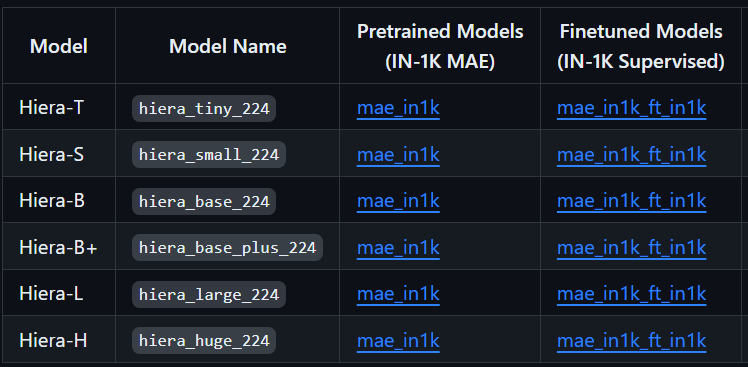

In [11]:
# # Numero de classes da base de análise de tecidos
# num_classes = 25

# # Carreagando o modelo, a menor versão de todas
# model = hiera.hiera_tiny_224(pretrained=True, checkpoint="mae_in1k_ft_in1k")

# #Congelando o modelo
# for param in model.parameters():
#     param.requires_grad = False

# # Substituindo ultima camada do modelo
# model.head.projection = nn.Linear(in_features=768, out_features=num_classes)

# # Reiniciando os pesos da ultima camada.
# nn.init.kaiming_normal_(model.head.projection.weight, mode='fan_out', nonlinearity='relu')
# # Numero de classes da base de análise de tecidos
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model_device = next(model.parameters()).device

# if device == "cuda" and model_device.type == "cpu":
#     model = model.to(device)
#     print("Model moved to GPU")

Definição das transformações

In [12]:
# input_size = 224

# # Lista para inserir as transformações de interesse
# transform_list = [transforms.Resize((input_size,input_size)),  # Resize to a slightly larger size
#                   ]
# # Modelo de transformação que não converte para tensor, de modo que seja possível visualizar a imagem final
# # (Isso tinha por padrão pq no modelo original eles fazer um zoom + crop central por algum motivo)
# transform_vis  = transforms.Compose(transform_list)

# # Convertendo para tensor e normalizando baseado na ImageNet
# transform_norm = transforms.Compose(transform_list + [
#     transforms.ToTensor(),
#     transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
# ])

### Treinamento

### Avaliando antes de realizar o treinamento, apenas com os pesos da base pré-treinada

### New dataset organizer pipeline

#### Functions

In [15]:
def split_and_move_for_calibration(dataset_base_path, num_images_per_class=5):
    """
    Move images from the 'train' subdirectory to a 'calibrate' subdirectory within each class.

    Parameters:
    dataset_base_path (str): The base path of the dataset containing 'train', 'test', etc.
    num_images_per_class (int): Number of images per class to move to the calibration set.
    """
    train_path = os.path.join(dataset_base_path, 'train')
    calibrate_path = os.path.join(dataset_base_path, 'calibrate')

    # Create the 'calibrate' directory if it doesn't exist
    if not os.path.exists(calibrate_path):
        os.makedirs(calibrate_path)

    # Iterate through each class in the 'train' directory
    for class_name in os.listdir(train_path):
        class_train_path = os.path.join(train_path, class_name)

        # Continue only if it's a directory
        if not os.path.isdir(class_train_path):
            continue

        # Create a corresponding class directory in 'calibrate'
        class_calibrate_path = os.path.join(calibrate_path, class_name)
        if not os.path.exists(class_calibrate_path):
            os.makedirs(class_calibrate_path)

        # Move the specified number of images to the 'calibrate' class directory
        images = os.listdir(class_train_path)[:num_images_per_class]
        for image in images:
            shutil.move(os.path.join(class_train_path, image), class_calibrate_path)

def load_hiera(num_classes):
    # Carreagando o modelo, a menor versão de todas
    model = hiera.hiera_tiny_224(pretrained=True, checkpoint="mae_in1k_ft_in1k")

    #Congelando o modelo
    for param in model.parameters():
      param.requires_grad = False

    # Substituindo ultima camada do modelo
    model.head.projection = nn.Linear(in_features=768, out_features=num_classes)

    # Reiniciando os pesos da ultima camada.
    nn.init.kaiming_normal_(model.head.projection.weight, mode='fan_out', nonlinearity='relu')

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model_device = next(model.parameters()).device

    if device == "cuda" and model_device.type == "cpu":
        model = model.to(device)
        print("Model moved to GPU")
    return model,device

def load_resnet50(num_classes):
    model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes) #são 9 classes

    # Congelando o modelo
    for param in model.parameters():
        param.requires_grad = False
    
    # Substituindo ultima camada do modelo
    model.fc = nn.Linear(in_features=2048, out_features=num_classes)

    # Reiniciando os pesos da ultima camada.
    nn.init.kaiming_normal_(model.fc.weight, mode='fan_out', nonlinearity='relu')

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model_device = next(model.parameters()).device

    if device == "cuda" and model_device.type == "cpu":
        model = model.to(device)
        print("Model moved to GPU")
    return model,device

def load_image_paths(dataset_path):
    cls_names = []
    image_paths = []
    train_path = os.path.join(dataset_path,'train')
    for cls in os.listdir(train_path):
      if os.path.isfile(os.path.join(train_path,cls,'1.jpg')):
        img_path = os.path.join(train_path,cls,'1.jpg')
      elif os.path.isfile(os.path.join(train_path,cls,'01.jpg')):
        img_path = os.path.join(train_path,cls,'01.jpg')
      elif os.path.isfile(os.path.join(train_path,cls,'001.jpg')):
        img_path = os.path.join(train_path,cls,'001.jpg')
      else:
        print("ERROR")
        return None
      image_paths.append(img_path)
      cls_names.append(cls)
    return image_paths,cls_names

def load_align_model():
  align_processor = AlignProcessor.from_pretrained('kakaobrain/align-base')
  align_model = AlignModel.from_pretrained('kakaobrain/align-base')
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print("Current device:", device)

  model_device = next(align_model.parameters()).device
  print("Model's current device:", model_device)

  if device == "cuda" and model_device.type == "cpu":
      align_model = align_model.to(device)
      print("Model moved to GPU")
  return align_model,align_processor

def batch_image_processing(image_paths,model,processor):
  current_batch = []
  features = []
  for img_path in tqdm(image_paths):
    current_batch.append(os.path.join(img_path))
    if len(current_batch) == 5:
      features.extend(process_images_with_align(current_batch,model,processor))
      current_batch = []
  return features

def process_images_with_align(image_paths,model,processor):
    images = [Image.open(img_path) for img_path in image_paths]
    for idx in range(len(images)):
      images[idx] = transform_vis(images[idx])
    inputs = processor(images=images, return_tensors="pt")

    inputs = {k: v.to(device) for k, v in inputs.items()}
    features = model.get_image_features(**inputs)
    return features.detach().cpu().numpy()

def recluster_and_select_classes(features, class_labels, num_clusters=25, num_iterations=21):
    """
    Re-cluster and select classes, ensuring 25 classes are selected in each iteration.

    Parameters:
    features (array): The features of the classes used for clustering.
    class_labels (list): The original class labels corresponding to each feature.
    num_clusters (int): Number of clusters for K-means.
    num_iterations (int): Number of iterations to select classes.

    Returns:
    dict: A dictionary where keys are iteration numbers and values are lists of selected class labels.
    """
    selected_classes_per_iteration = {}
    all_selected_classes = set()

    for iteration in range(num_iterations):
        if iteration > 0 or 'cluster_labels' not in locals():
            # Re-run K-means clustering on the remaining classes
            remaining_features = [features[i] for i, cls in enumerate(class_labels) if cls not in all_selected_classes]
            remaining_labels = [cls for cls in class_labels if cls not in all_selected_classes]
            cluster_labels = kmeans_clustering(remaining_features, num_clusters)

            # Map new clusters to remaining class labels
            cluster_to_classes = map_clusters_to_classes(cluster_labels, remaining_labels)

        selected_classes = []
        print(f"\nIteration {iteration+1}/{num_iterations}:")

        for cluster, classes in cluster_to_classes.items():
            available_classes = [cls for cls in classes if cls not in all_selected_classes]
            print(f"  Cluster {cluster}: Available classes - {available_classes}")

            if available_classes:
                selected_class = random.choice(available_classes)
                selected_classes.append(selected_class)
                all_selected_classes.add(selected_class)
                print(f"    Selected class: {selected_class}")

            if len(selected_classes) == 25:
                break

        selected_classes_per_iteration[iteration] = selected_classes
        print(f"  Classes selected in this iteration: {selected_classes}")
        print(f"  Total selected classes so far: {len(all_selected_classes)}")

        # If all classes are selected, break the loop
        if len(all_selected_classes) == len(class_labels):
            break

    return selected_classes_per_iteration

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def create_subsets(dataset_path, groups_json_path):
    # Load dataset
    full_dataset = datasets.ImageFolder(root=dataset_path)
    class_to_idx = full_dataset.class_to_idx

    # Load groups from JSON
    groups = load_json(groups_json_path)

    # Dictionary to store indices for each group
    indices_dict = {}

    # Iterate over groups to create subsets
    for group_number, class_names in tqdm(groups.items(), desc="Creating subsets"):
        # Find indices for each class in the group
        group_indices = []
        for class_name in class_names:
            if class_name in class_to_idx:
                class_idx = class_to_idx[class_name]
                group_indices.extend([i for i, (_, label) in enumerate(full_dataset.samples) if label == class_idx])
            else:
                print(f"Class {class_name} not found in dataset")

        # Store indices in dictionary
        indices_dict[group_number] = group_indices

    return indices_dict

def get_combined_indices(indices_dict, num_groups):
    """
    Combine indices from multiple groups to create a larger group.

    Parameters:
    indices_dict (dict): Dictionary containing indices for each group.
    num_groups (int): Number of groups to combine.

    Returns:
    list: Combined indices from the specified number of groups.
    """
    combined_indices = []
    for i in range(num_groups):
        group_number = f'{i}'  # Adjust based on your group naming convention
        combined_indices.extend(indices_dict[group_number])
    return combined_indices

# Load your dataset (assuming you have a Subset)
def load_filter_remap_dataset(dataset_path,indices,transform):
  full_dataset = datasets.ImageFolder(root=dataset_path,transform=transform)
  filtered_dataset = torch.utils.data.Subset(full_dataset, indices)
  # Remap class indices
  remapped_train_dataset, class_mapping = remap_class_indices(filtered_dataset,transform)
  return remapped_train_dataset, class_mapping

def remap_class_indices(dataset, transform):
    """
    Remap class indices of a dataset to a new range (0 to N-1) and return a new ImageFolder dataset.

    Parameters:
    dataset (Subset): The dataset whose class indices are to be remapped.
    transform (transforms.Compose): Transformations to be applied to the dataset.

    Returns:
    Tuple[ImageFolder, dict]: A tuple containing the remapped dataset and a mapping dictionary.
    """
    unique_labels = set([dataset.dataset.samples[i][1] for i in dataset.indices])
    original_to_new_mapping = {original: new for new, original in enumerate(sorted(unique_labels))}

    # Create a new dataset with remapped labels
    remapped_samples = [(dataset.dataset.samples[i][0], original_to_new_mapping[dataset.dataset.samples[i][1]]) for i in dataset.indices]
    remapped_dataset = datasets.ImageFolder(dataset.dataset.root, transform=transform)
    remapped_dataset.samples = remapped_samples

    return remapped_dataset, original_to_new_mapping

In [14]:
# split_and_move_for_calibration(BIRDS_PATH, num_images_per_class=5)

#### Pipeline preparação dos datasets

In [15]:
# image_paths, class_labels = load_image_paths(BIRDS_PATH)

# model,processor = load_align_model()

# features = batch_image_processing(image_paths,model,processor)

# # Select classes from clusters
# selected_classes_per_iteration = recluster_and_select_classes(features, class_labels, num_clusters=25, num_iterations=21)

In [16]:
# for key in selected_classes_per_iteration.keys():
#   print(len(selected_classes_per_iteration[key]),selected_classes_per_iteration[key])

In [17]:
# import json
# with open(f"{BIRDS_PATH}/groups.json",'w') as file:
#   json.dump(selected_classes_per_iteration,file)

In [18]:
# # Paths
# train_path = BIRDS_PATH + '/train'
# valid_path = BIRDS_PATH + '/valid'
# test_path = BIRDS_PATH + '/test'
# calibrate_path = BIRDS_PATH + '/calibrate'
# groups_json_path = f"{BIRDS_PATH}/groups.json"

# # Create subsets
# train_indices_dict = create_subsets(train_path, groups_json_path)
# valid_indices_dict = create_subsets(valid_path, groups_json_path)
# test_indices_dict = create_subsets(test_path, groups_json_path)
# calibrate_indices_dict = create_subsets(calibrate_path, groups_json_path)

# # Optionally, save the indices_dict as a JSON file for later use
# with open(os.path.join(BIRDS_PATH, 'train_indices_dict.json'), 'w') as json_file:
#     json.dump(train_indices_dict, json_file)

# # Optionally, save the indices_dict as a JSON file for later use
# with open(os.path.join(BIRDS_PATH, 'valid_indices_dict.json'), 'w') as json_file:
#     json.dump(valid_indices_dict, json_file)

# # Optionally, save the indices_dict as a JSON file for later use
# with open(os.path.join(BIRDS_PATH, 'test_indices_dict.json'), 'w') as json_file:
#     json.dump(test_indices_dict, json_file)

# with open(os.path.join(BIRDS_PATH, 'calibrate_indices_dict.json'), 'w') as json_file:
#     json.dump(calibrate_indices_dict, json_file)

#### Carregando datasets

In [19]:
# # Paths
# train_path = BIRDS_PATH + '/train'
# valid_path = BIRDS_PATH + '/valid'
# test_path = BIRDS_PATH + '/test'
# calibrate_path = BIRDS_PATH + '/calibrate'
# groups_json_path = f"{BIRDS_PATH}/groups.json"
# # Optionally, save the indices_dict as a JSON file for later use
# with open(os.path.join(BIRDS_PATH, 'train_indices_dict.json'), 'r') as json_file:
#     train_indices_dict = json.load(json_file)

# # Optionally, save the indices_dict as a JSON file for later use
# with open(os.path.join(BIRDS_PATH, 'valid_indices_dict.json'), 'r') as json_file:
#     valid_indices_dict = json.load(json_file)

# # Optionally, save the indices_dict as a JSON file for later use
# with open(os.path.join(BIRDS_PATH, 'test_indices_dict.json'), 'r') as json_file:
#     test_indices_dict = json.load(json_file)

# with open(os.path.join(BIRDS_PATH, 'calibrate_indices_dict.json'), 'r') as json_file:
#     calibrate_indices_dict = json.load(json_file)
    

In [20]:
# # Load your dataset (assuming you have a Subset)
# def load_filter_remap_dataset(dataset_path,indices,transform):
#   full_dataset = datasets.ImageFolder(root=dataset_path,transform=transform)
#   filtered_dataset = torch.utils.data.Subset(full_dataset, indices)
#   # Remap class indices
#   remapped_train_dataset, class_mapping = remap_class_indices(filtered_dataset,transform)
#   return remapped_train_dataset, class_mapping

# remapped_train_dataset, train_class_mapping = load_filter_remap_dataset(train_path,train_indices_dict['0'],transform_norm)
# remapped_valid_dataset, valid_class_mapping = load_filter_remap_dataset(valid_path,valid_indices_dict['0'],transform_norm)
# remapped_test_dataset, test_class_mapping = load_filter_remap_dataset(test_path,test_indices_dict['0'],transform_norm)
# remapped_calibrate_dataset, calibrate_class_mapping = load_filter_remap_dataset(calibrate_path,calibrate_indices_dict['0'],transform_norm)

# # Print class mapping for reference

# for (train_original, train_new), (valid_original, valid_new), (test_original, test_new), (cali_original,cali_new)  in zip(train_class_mapping.items(), valid_class_mapping.items(), test_class_mapping.items(), calibrate_class_mapping.items()):
#     print(f"Train Original Index: {train_original}, Train New Index: {train_new} | "
#           f"Valid Original Index: {valid_original}, Valid New Index: {valid_new} | "
#           f"Test Original Index: {test_original}, Test New Index: {test_new} | "
#           f"Cali Original Index: {cali_original}, Cali New Index: {cali_new} | ")

# Remaning code

Checando se resultado está Coerente

In [21]:
# N_CLASSES = 25
# # Batch size for the DataLoader
# batch_size = 32

# # Creating DataLoaders for each subset
# train_loader = DataLoader(remapped_train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(remapped_valid_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(remapped_test_dataset, batch_size=batch_size, shuffle=False)
# calibration_loader = DataLoader(remapped_calibrate_dataset, batch_size=batch_size, shuffle=False)


### Epoch

Definindo o paso a passo a ser realizado por época de treinamento

In [22]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Current device:", device)

# model_device = next(model.parameters()).device
# print("Model's current device:", model_device)

# if device == "cuda" and model_device.type == "cpu":
#     model = model.to(device)
#     print("Model moved to GPU")

In [16]:
import time

def epoch(model,train_loader,valid_loader,results_path, training_index, num_epochs = 2, frozen = "Frozen",model_name = "hiera"):
    summary = { #Dicionário que armazenará o resumo do estado do modelo, métricas e matriz confusões
        'f1_history':[],
        'acc_history':[],
        'train_loss_history':[],
        'val_loss_history': [],
        'auc': []
    }

    save_model = False
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Definindo o device padrão como 'cuda'
    print(device)
    best_acc = 0.0
    lowest_loss = 10000000000000000
    optimizer = update_optimizer(model, frozen,model_name)
    criterion = nn.CrossEntropyLoss()
    #   debug_model_and_optimizer(model, optimizer)
    # Training loop
    for epoch in range(num_epochs):
        # Time
        start_time = time.time()    
        val_loss = 0
        train_loss = 0
        model.cuda()
        model.train()
        training_logits = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            training_logits.append(outputs.cpu().detach().numpy())
        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        all_labels = []
        all_preds = []
        all_logits = []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                all_labels.append(labels.cpu().numpy())
                all_preds.append(predicted.cpu().numpy())
                all_logits.append(outputs.cpu().numpy())

        val_loss /= len(valid_loader)
        
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        all_logits = np.concatenate(all_logits)
        training_logits = np.concatenate(training_logits)
        # all_labels_oneshot = np.eye(N_CLASSES)[all_labels]
        # Compute accuracy and confusion matrix
        # Print first values of logits and labels

        accuracy = accuracy_score(all_labels, all_preds)
        conf_matrix = confusion_matrix(all_labels, all_preds)
        f1 = f1_score(y_true=all_labels, y_pred=all_preds, average='weighted')
        probabilities = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
        auc = roc_auc_score(all_labels,probabilities, multi_class='ovr')
        #Salvando métricas, estado do modelo e matriz confusão
        np.save(os.path.join(results_path,model_name,'confusion_matrix', f'conf_matrix_t{training_index}_e{epoch}_{frozen}.npy'), conf_matrix)
        summary['f1_history'].append(f1)
        summary['acc_history'].append(accuracy)
        summary['train_loss_history'].append(train_loss)
        summary['val_loss_history'].append(val_loss)
        summary['auc'].append(auc)
        # summary['calibrate'].append((ece, nll, mse, accu, ci, entropy))
        if accuracy > best_acc:
            best_acc = accuracy
            save_model = True
        if val_loss < lowest_loss:
            lowest_loss = val_loss
            save_model = True
        # print(f'Confusion Matrix:\n{conf_matrix}')
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy} | Valitation Loss: {loss.item()} | Time elapsed: {(time.time() - start_time):.2f} seconds")
        if epoch+1 == num_epochs or save_model:
            torch.save(model.state_dict(), os.path.join(results_path,model_name,'model_state', f'model_state_t{training_index}_e{epoch}_{frozen}.pth'))
            save_model = False

    if frozen == "Frozen":
        return summary,model
    else:
        return summary


# Function to print the state of the first few parameters and the optimizer
def debug_model_and_optimizer(model, optimizer):
    print("First few model parameters and their 'requires_grad' status:")
    for name, param in model.named_parameters():
        print(f"{name}: {param.requires_grad}")
        if "layer4" in name:  # Adjust this condition to limit the output
            break

    # Print optimizer state (focus on learning rate)
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate: {param_group['lr']}")



# Example function to update the optimizer for different training phases
def update_optimizer(model, frozen,model_name):
    if frozen == "Frozen":
        if model_name == 'hiera':
            # Only optimize parameters in model.head.projection
            optimizer = Adam(model.head.projection.parameters(), lr=1e-3)
        else:
            # Only optimize parameters in model.fc
            optimizer = Adam(model.fc.parameters(), lr=1e-3)
    else:
        # Optimize all parameters in the model
        optimizer = Adam(model.parameters(), lr=5e-5)
    
    # Zero out any existing gradients
    optimizer.zero_grad()

    return optimizer


In [17]:
def train_and_save_results(results_path,transform_norm,batch_size = 32,num_epochs = (20,0), training_index = 21,model_name = "hiera"):
    # for idx in range(groups_number):
    frozen_epochs, unfrozen_epochs = num_epochs
    N_CLASSES = int(training_index*25)
    print(f"EXECUTING TRAINING NUMBER {training_index} WITH {N_CLASSES} CLASSES")
    if model_name == "hiera":
        model,device = load_hiera(N_CLASSES)
    else:
        model,device = load_resnet50(N_CLASSES)
        
    train_path = BIRDS_PATH + '/train'
    valid_path = BIRDS_PATH + '/valid'
    test_path = BIRDS_PATH + '/test'
    calibrate_path = BIRDS_PATH + '/calibrate'

    with open(os.path.join(BIRDS_PATH, 'train_indices_dict.json'), 'r') as json_file:
        train_indices_dict = json.load(json_file)

    # Optionally, save the indices_dict as a JSON file for later use
    with open(os.path.join(BIRDS_PATH, 'valid_indices_dict.json'), 'r') as json_file:
        valid_indices_dict = json.load(json_file)

    # Optionally, save the indices_dict as a JSON file for later use
    with open(os.path.join(BIRDS_PATH, 'test_indices_dict.json'), 'r') as json_file:
        test_indices_dict = json.load(json_file)

    # Optionally, save the indices_dict as a JSON file for later use
    with open(os.path.join(BIRDS_PATH, 'calibrate_indices_dict.json'), 'r') as json_file:
        calibrate_indices_dict = json.load(json_file)

    remapped_train_dataset, train_class_mapping = load_filter_remap_dataset(train_path,get_combined_indices(train_indices_dict,training_index),transform_norm)
    remapped_valid_dataset, valid_class_mapping = load_filter_remap_dataset(valid_path,get_combined_indices(valid_indices_dict,training_index),transform_norm)
    # remapped_test_dataset, test_class_mapping = load_filter_remap_dataset(test_path,get_combined_indices(test_indices_dict,training_index),transform_norm)
    # remapped_calibrate_dataset, calibrate_class_mapping = load_filter_remap_dataset(calibrate_path,get_combined_indices(calibrate_indices_dict,training_index),transform_norm)
    # Batch size for the DataLoader


    # Creating DataLoaders for each subset
    train_loader = DataLoader(remapped_train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(remapped_valid_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(remapped_test_dataset, batch_size=batch_size, shuffle=False)
    # calibration_loader = DataLoader(remapped_calibrate_dataset, batch_size=batch_size, shuffle=True)

    if frozen_epochs > 0:
        
        frozen_summary,model  = epoch(model,train_loader,valid_loader,results_path,training_index,num_epochs=frozen_epochs,frozen="Frozen",model_name = model_name)
        with open(os.path.join(results_path,model_name,'summary',f'frozen_summary_{training_index}.json'),'w') as file:
            json.dump(frozen_summary,file)
    
    if unfrozen_epochs > 0:
        
        print("Unfreezing model")
        # unfreeze model
        for param in model.parameters():
            param.requires_grad = True
        
        print("Starting Fine Tuning")
        unfrozen_summary  = epoch(model,train_loader,valid_loader,results_path,training_index,num_epochs=unfrozen_epochs,frozen="Unfrozen")
        with open(os.path.join(results_path,model_name,'summary',f'unfrozen_summary_{training_index}.json'),'w') as file:
            json.dump(unfrozen_summary,file)

In [18]:
input_size = 224

# Lista para inserir as transformações de interesse
transform_list = [transforms.Resize((input_size,input_size)),  # Resize to a slightly larger size
                  ]
# Modelo de transformação que não converte para tensor, de modo que seja possível visualizar a imagem final
# (Isso tinha por padrão pq no modelo original eles fazer um zoom + crop central por algum motivo)
transform_vis  = transforms.Compose(transform_list)

# Convertendo para tensor e normalizando baseado na ImageNet
transform_norm = transforms.Compose(transform_list + [
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

In [29]:
for idx in range(3,22):
    train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=idx)

EXECUTING TRAINING NUMBER 3 WITH 75 CLASSES
Model moved to GPU
cuda
Epoch 1/10, Validation Accuracy: 0.96 | Valitation Loss: 3.4521312713623047 | Time elapsed: 124.44 seconds
Epoch 2/10, Validation Accuracy: 0.976 | Valitation Loss: 3.406787872314453 | Time elapsed: 124.32 seconds
Epoch 3/10, Validation Accuracy: 0.9813333333333333 | Valitation Loss: 3.3567562103271484 | Time elapsed: 123.34 seconds
Epoch 4/10, Validation Accuracy: 0.984 | Valitation Loss: 3.379824161529541 | Time elapsed: 124.15 seconds
Epoch 5/10, Validation Accuracy: 0.9973333333333333 | Valitation Loss: 3.391814947128296 | Time elapsed: 123.67 seconds
Epoch 6/10, Validation Accuracy: 0.992 | Valitation Loss: 3.350614547729492 | Time elapsed: 124.73 seconds
Epoch 7/10, Validation Accuracy: 0.9973333333333333 | Valitation Loss: 3.350067138671875 | Time elapsed: 123.10 seconds
Epoch 8/10, Validation Accuracy: 0.992 | Valitation Loss: 3.378377676010132 | Time elapsed: 123.86 seconds
Epoch 9/10, Validation Accuracy: 0.9

KeyboardInterrupt: 

In [31]:
train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=21)

EXECUTING TRAINING NUMBER 21 WITH 525 CLASSES
Model moved to GPU
cuda
Epoch 1/10, Validation Accuracy: 0.915047619047619 | Valitation Loss: 5.456273555755615 | Time elapsed: 1299.12 seconds
Epoch 2/10, Validation Accuracy: 0.936 | Valitation Loss: 5.473758697509766 | Time elapsed: 890.45 seconds
Epoch 3/10, Validation Accuracy: 0.9500952380952381 | Valitation Loss: 5.375472068786621 | Time elapsed: 867.78 seconds
Epoch 4/10, Validation Accuracy: 0.9497142857142857 | Valitation Loss: 5.356832027435303 | Time elapsed: 873.26 seconds
Epoch 5/10, Validation Accuracy: 0.9542857142857143 | Valitation Loss: 5.307406425476074 | Time elapsed: 867.49 seconds
Epoch 6/10, Validation Accuracy: 0.9531428571428572 | Valitation Loss: 5.474924564361572 | Time elapsed: 924.69 seconds
Epoch 7/10, Validation Accuracy: 0.9580952380952381 | Valitation Loss: 5.3636088371276855 | Time elapsed: 975.13 seconds
Epoch 8/10, Validation Accuracy: 0.9535238095238096 | Valitation Loss: 5.292716026306152 | Time elapse

In [8]:
for idx in range(8,11):
    train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=idx,model_name="resnet50")

EXECUTING TRAINING NUMBER 8 WITH 200 CLASSES
Model moved to GPU
cuda
Epoch 1/10, Validation Accuracy: 0.806 | Valitation Loss: 1.1061526536941528 | Time elapsed: 778.46 seconds
Epoch 2/10, Validation Accuracy: 0.884 | Valitation Loss: 0.22762997448444366 | Time elapsed: 222.45 seconds
Epoch 3/10, Validation Accuracy: 0.908 | Valitation Loss: 0.2116546332836151 | Time elapsed: 223.29 seconds
Epoch 4/10, Validation Accuracy: 0.911 | Valitation Loss: 0.06396433711051941 | Time elapsed: 226.88 seconds
Epoch 5/10, Validation Accuracy: 0.928 | Valitation Loss: 0.051345404237508774 | Time elapsed: 242.27 seconds
Epoch 6/10, Validation Accuracy: 0.937 | Valitation Loss: 0.05283737927675247 | Time elapsed: 235.45 seconds
Epoch 7/10, Validation Accuracy: 0.932 | Valitation Loss: 0.03509599342942238 | Time elapsed: 236.89 seconds
Epoch 8/10, Validation Accuracy: 0.943 | Valitation Loss: 0.044596534222364426 | Time elapsed: 235.69 seconds
Epoch 9/10, Validation Accuracy: 0.939 | Valitation Loss: 0

In [9]:
train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=21,model_name="resnet50")

EXECUTING TRAINING NUMBER 21 WITH 525 CLASSES
Model moved to GPU
cuda
Epoch 1/10, Validation Accuracy: 0.7855238095238095 | Valitation Loss: 2.1059558391571045 | Time elapsed: 1257.50 seconds
Epoch 2/10, Validation Accuracy: 0.8506666666666667 | Valitation Loss: 1.3111332654953003 | Time elapsed: 595.24 seconds
Epoch 3/10, Validation Accuracy: 0.8826666666666667 | Valitation Loss: 0.9318848848342896 | Time elapsed: 598.47 seconds
Epoch 4/10, Validation Accuracy: 0.8918095238095238 | Valitation Loss: 0.9630813598632812 | Time elapsed: 597.62 seconds
Epoch 5/10, Validation Accuracy: 0.9078095238095238 | Valitation Loss: 0.9402266144752502 | Time elapsed: 601.97 seconds
Epoch 6/10, Validation Accuracy: 0.894095238095238 | Valitation Loss: 0.5760376453399658 | Time elapsed: 600.96 seconds
Epoch 7/10, Validation Accuracy: 0.9100952380952381 | Valitation Loss: 0.5801447033882141 | Time elapsed: 602.94 seconds
Epoch 8/10, Validation Accuracy: 0.9074285714285715 | Valitation Loss: 0.5273306965

In [10]:
for idx in range(11,15):
    train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=idx,model_name="resnet50")

EXECUTING TRAINING NUMBER 11 WITH 275 CLASSES
Model moved to GPU
cuda
Epoch 1/10, Validation Accuracy: 0.7992727272727272 | Valitation Loss: 1.6463801860809326 | Time elapsed: 315.95 seconds
Epoch 2/10, Validation Accuracy: 0.8763636363636363 | Valitation Loss: 1.1423747539520264 | Time elapsed: 314.37 seconds
Epoch 3/10, Validation Accuracy: 0.904 | Valitation Loss: 0.5950680375099182 | Time elapsed: 318.32 seconds
Epoch 4/10, Validation Accuracy: 0.9047272727272727 | Valitation Loss: 0.8823211193084717 | Time elapsed: 314.42 seconds
Epoch 5/10, Validation Accuracy: 0.9156363636363636 | Valitation Loss: 0.673627495765686 | Time elapsed: 315.70 seconds
Epoch 6/10, Validation Accuracy: 0.9076363636363637 | Valitation Loss: 0.6564604043960571 | Time elapsed: 316.50 seconds
Epoch 7/10, Validation Accuracy: 0.9294545454545454 | Valitation Loss: 0.6941856145858765 | Time elapsed: 316.78 seconds
Epoch 8/10, Validation Accuracy: 0.9272727272727272 | Valitation Loss: 0.5992727279663086 | Time 

In [11]:
for idx in range(19,21):
    train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=idx,model_name="resnet50")

EXECUTING TRAINING NUMBER 19 WITH 475 CLASSES
Model moved to GPU
cuda
Epoch 1/10, Validation Accuracy: 0.7928421052631579 | Valitation Loss: 1.2047380208969116 | Time elapsed: 543.74 seconds
Epoch 2/10, Validation Accuracy: 0.8501052631578947 | Valitation Loss: 0.3708060383796692 | Time elapsed: 544.99 seconds
Epoch 3/10, Validation Accuracy: 0.872 | Valitation Loss: 0.3126067519187927 | Time elapsed: 545.53 seconds
Epoch 4/10, Validation Accuracy: 0.9006315789473684 | Valitation Loss: 0.0718575045466423 | Time elapsed: 544.25 seconds
Epoch 5/10, Validation Accuracy: 0.9048421052631579 | Valitation Loss: 0.12486479431390762 | Time elapsed: 545.72 seconds
Epoch 6/10, Validation Accuracy: 0.9124210526315789 | Valitation Loss: 0.15598030388355255 | Time elapsed: 545.23 seconds
Epoch 7/10, Validation Accuracy: 0.9153684210526316 | Valitation Loss: 0.04794631525874138 | Time elapsed: 541.88 seconds
Epoch 8/10, Validation Accuracy: 0.911578947368421 | Valitation Loss: 0.034480445086956024 | 

KeyboardInterrupt: 

In [ ]:
for idx in range(19,21):
    train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=idx)

In [ ]:
for idx in range(15,19):
    train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=idx,model_name="resnet50")

In [ ]:
for idx in range(15,19):
    train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=idx)

In [9]:
train_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,num_epochs=(10,0),training_index=1)

EXECUTING TRAINING NUMBER 1 WITH 25 CLASSES
Model moved to GPU
cuda
Epoch 1/10, Validation Accuracy: 0.848 | Valitation Loss: 2.818788766860962 | Time elapsed: 100.25 seconds
Epoch 2/10, Validation Accuracy: 0.968 | Valitation Loss: 2.5465588569641113 | Time elapsed: 39.28 seconds
Epoch 3/10, Validation Accuracy: 0.976 | Valitation Loss: 2.4157509803771973 | Time elapsed: 39.57 seconds
Epoch 4/10, Validation Accuracy: 0.992 | Valitation Loss: 2.348222494125366 | Time elapsed: 39.70 seconds
Epoch 5/10, Validation Accuracy: 0.992 | Valitation Loss: 2.326162576675415 | Time elapsed: 39.86 seconds
Epoch 6/10, Validation Accuracy: 0.992 | Valitation Loss: 2.3204615116119385 | Time elapsed: 39.85 seconds
Epoch 7/10, Validation Accuracy: 1.0 | Valitation Loss: 2.307626247406006 | Time elapsed: 39.69 seconds
Epoch 8/10, Validation Accuracy: 1.0 | Valitation Loss: 2.3014049530029297 | Time elapsed: 39.91 seconds
Epoch 9/10, Validation Accuracy: 0.992 | Valitation Loss: 2.3000922203063965 | Time

# Calibração

Vamos usar a função ets_calibrate para calibrar a base dos pássaros (muitas classes), e a função mir_calibrate para calibrar a base de raio x (poucas classes);

As funções recebem:


*   logit - array de logits da base de calibração com dimensões (n_instances, n_classes);
*   label - array de true labels da base de calibração no formato de one-hot encoding com dimensões (n_instances, n_classes);
*   logit_eval - array de logits da base de teste com dimensões (n_instances,n_classes);
*   n_class - inteiro com a quantidade de classes;
*   loss - string informando o tipo de loss que será utilizada, pode ser 'mse' ou 'ce'. Porém vamos utilizar a 'mse'.



In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Jize Zhang
"""

import numpy as np
from scipy import optimize
from sklearn.isotonic import IsotonicRegression

"""
auxiliary functions for optimizing the temperature (scaling approaches) and weights of ensembles
*args include logits and labels from the calibration dataset:
"""

def mse_t(t, *args):
## find optimal temperature with MSE loss function

    logit, label = args
    logit = logit/t
    n = np.sum(np.exp(logit),1)
    p = np.exp(logit)/n[:,None]
    mse = np.mean((p-label)**2)
    return mse


def ll_t(t, *args):
## find optimal temperature with Cross-Entropy loss function

    logit, label = args
    logit = logit/t
    n = np.sum(np.exp(logit),1)
    p = np.clip(np.exp(logit)/n[:,None],1e-20,1-1e-20)
    N = p.shape[0]
    ce = -np.sum(label*np.log(p))/N
    return ce



def mse_w(w, *args):
## find optimal weight coefficients with MSE loss function

    p0, p1, p2, label = args
    p = w[0]*p0+w[1]*p1+w[2]*p2
    p = p/np.sum(p,1)[:,None]
    mse = np.mean((p-label)**2)
    return mse


def ll_w(w, *args):
## find optimal weight coefficients with Cros-Entropy loss function

    p0, p1, p2, label = args
    p = (w[0]*p0+w[1]*p1+w[2]*p2)
    N = p.shape[0]
    ce = -np.sum(label*np.log(p))/N
    return ce


##### Ftting Temperature Scaling
def temperature_scaling(logit,label,loss):

    bnds = ((0.05, 5.0),)
    if loss == 'ce':
       t = optimize.minimize(ll_t, 1.0 , args = (logit,label), method='L-BFGS-B', bounds=bnds, tol=1e-12)
    if loss == 'mse':
        t = optimize.minimize(mse_t, 1.0 , args = (logit,label), method='L-BFGS-B', bounds=bnds, tol=1e-12)
    t = t.x
    return t



##### Ftting Enseble Temperature Scaling
def ensemble_scaling(logit,label,loss,t,n_class):

    p1 = np.exp(logit)/np.sum(np.exp(logit),1)[:,None]
    logit = logit/t
    p0 = np.exp(logit)/np.sum(np.exp(logit),1)[:,None]
    p2 = np.ones_like(p0)/n_class


    bnds_w = ((0.0, 1.0),(0.0, 1.0),(0.0, 1.0),)
    def my_constraint_fun(x): return np.sum(x)-1
    constraints = { "type":"eq", "fun":my_constraint_fun,}
    if loss == 'ce':
        w = optimize.minimize(ll_w, (1.0, 0.0, 0.0) , args = (p0,p1,p2,label), method='SLSQP', constraints = constraints, bounds=bnds_w, tol=1e-12, options={'disp': True})
    if loss == 'mse':
        w = optimize.minimize(mse_w, (1.0, 0.0, 0.0) , args = (p0,p1,p2,label), method='SLSQP', constraints = constraints, bounds=bnds_w, tol=1e-12, options={'disp': True})
    w = w.x
    return w





"""
Calibration:
Input: uncalibrated logits, temperature (and weight)
Output: calibrated prediction probabilities
"""

##### Calibration: Temperature Scaling with MSE
def ts_calibrate(logit,label,logit_eval,loss):
    t = temperature_scaling(logit,label,loss)
    print("temperature = " +str(t))
    logit_eval = logit_eval/t
    p = np.exp(logit_eval)/np.sum(np.exp(logit_eval),1)[:,None]
    return p


##### Calibration: Ensemble Temperature Scaling
def ets_calibrate(logit,label,logit_eval,n_class,loss):
    t = temperature_scaling(logit,label,loss='mse') # loss can change to 'ce'
    print("temperature = " +str(t))
    w = ensemble_scaling(logit,label,'mse',t,n_class)
    print("weight = " +str(w))



    p1 = np.exp(logit_eval)/np.sum(np.exp(logit_eval),1)[:,None]
    logit_eval = logit_eval/t
    p0 = np.exp(logit_eval)/np.sum(np.exp(logit_eval),1)[:,None]
    p2 = np.ones_like(p0)/n_class
    p = w[0]*p0 + w[1]*p1 +w[2]*p2
    return p



##### Calibration: Isotonic Regression (Multi-class)
def mir_calibrate(logit,label,logit_eval):
    p = np.exp(logit)/np.sum(np.exp(logit),1)[:,None]
    p_eval = np.exp(logit_eval)/np.sum(np.exp(logit_eval),1)[:,None]
    ir = IsotonicRegression(out_of_bounds='clip')
    y_ = ir.fit_transform(p.flatten(), (label.flatten()))
    yt_ = ir.predict(p_eval.flatten())

    p = yt_.reshape(logit_eval.shape)+1e-9*p_eval
    return p

def irova_calibrate(logit,label,logit_eval):
    p = np.exp(logit)/np.sum(np.exp(logit),1)[:,None]
    p_eval = np.exp(logit_eval)/np.sum(np.exp(logit_eval),1)[:,None]


    for ii in range(p_eval.shape[1]):
        ir = IsotonicRegression(out_of_bounds='clip')
        y_ = ir.fit_transform(p[:,ii], label[:,ii])
        p_eval[:,ii] = ir.predict(p_eval[:,ii])+1e-9*p_eval[:,ii]
    return p_eval
    return p_eval

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 18 22:58:58 2019

@author: zhang64
"""


import torch
import numpy as np
import torch.nn.parallel

from KDEpy import FFTKDE


def mirror_1d(d, xmin=None, xmax=None):
    """If necessary apply reflecting boundary conditions."""
    if xmin is not None and xmax is not None:
        xmed = (xmin+xmax)/2
        return np.concatenate(((2*xmin-d[d < xmed]).reshape(-1,1), d, (2*xmax-d[d >= xmed]).reshape(-1,1)))
    elif xmin is not None:
        return np.concatenate((2*xmin-d, d))
    elif xmax is not None:
        return np.concatenate((d, 2*xmax-d))
    else:
        return d


def ece_kde_binary(p,label,p_int=None,order=1):

    # points from numerical integration
    if p_int is None:
        p_int = np.copy(p)

    p = np.clip(p,1e-256,1-1e-256)
    p_int = np.clip(p_int,1e-256,1-1e-256)


    x_int = np.linspace(-0.6, 1.6, num=2**14)


    N = p.shape[0]

    # this is needed to convert labels from one-hot to conventional form
    label_index = np.array([np.where(r==1)[0][0] for r in label])
    with torch.no_grad():
        if p.shape[1] !=2:
            p_new = torch.from_numpy(p)
            p_b = torch.zeros(N,1)
            label_binary = np.zeros((N,1))
            for i in range(N):
                pred_label = int(torch.argmax(p_new[i]).numpy())
                if pred_label == label_index[i]:
                    label_binary[i] = 1
                p_b[i] = p_new[i,pred_label]/torch.sum(p_new[i,:])
        else:
            p_b = torch.from_numpy((p/np.sum(p,1)[:,None])[:,1])
            label_binary = label_index

    method = 'triweight'

    dconf_1 = (p_b[np.where(label_binary==1)].reshape(-1,1)).numpy()
    kbw = np.std(p_b.numpy())*(N*2)**-0.2
    kbw = np.std(dconf_1)*(N*2)**-0.2
    # Mirror the data about the domain boundary
    low_bound = 0.0
    up_bound = 1.0
    dconf_1m = mirror_1d(dconf_1,low_bound,up_bound)
    # Compute KDE using the bandwidth found, and twice as many grid points
    pp1 = FFTKDE(bw=kbw, kernel=method).fit(dconf_1m).evaluate(x_int)
    pp1[x_int<=low_bound] = 0  # Set the KDE to zero outside of the domain
    pp1[x_int>=up_bound] = 0  # Set the KDE to zero outside of the domain
    pp1 = pp1 * 2  # Double the y-values to get integral of ~1


    p_int = p_int/np.sum(p_int,1)[:,None]
    N1 = p_int.shape[0]
    with torch.no_grad():
        p_new = torch.from_numpy(p_int)
        pred_b_int = np.zeros((N1,1))
        if p_int.shape[1]!=2:
            for i in range(N1):
                pred_label = int(torch.argmax(p_new[i]).numpy())
                pred_b_int[i] = p_int[i,pred_label]
        else:
            for i in range(N1):
                pred_b_int[i] = p_int[i,1]

    low_bound = 0.0
    up_bound = 1.0
    pred_b_intm = mirror_1d(pred_b_int,low_bound,up_bound)
    # Compute KDE using the bandwidth found, and twice as many grid points
    pp2 = FFTKDE(bw=kbw, kernel=method).fit(pred_b_intm).evaluate(x_int)
    pp2[x_int<=low_bound] = 0  # Set the KDE to zero outside of the domain
    pp2[x_int>=up_bound] = 0  # Set the KDE to zero outside of the domain
    pp2 = pp2 * 2  # Double the y-values to get integral of ~1


    if p.shape[1] !=2: # top label (confidence)
        perc = np.mean(label_binary)
    else: # or joint calibration for binary cases
        perc = np.mean(label_index)

    integral = np.zeros(x_int.shape)
    reliability= np.zeros(x_int.shape)
    for i in range(x_int.shape[0]):
        conf = x_int[i]
        if np.max([pp1[np.abs(x_int-conf).argmin()],pp2[np.abs(x_int-conf).argmin()]])>1e-6:
            accu = np.min([perc*pp1[np.abs(x_int-conf).argmin()]/pp2[np.abs(x_int-conf).argmin()],1.0])
            if np.isnan(accu)==False:
                integral[i] = np.abs(conf-accu)**order*pp2[i]
                reliability[i] = accu
        else:
            if i>1:
                integral[i] = integral[i-1]

    ind = np.where((x_int >= 0.0) & (x_int <= 1.0))
    return np.trapz(integral[ind],x_int[ind])/np.trapz(pp2[ind],x_int[ind])


def ece_hist_binary(p, label, n_bins = 15, order=1):

    p = np.clip(p,1e-256,1-1e-256)

    N = p.shape[0]
    label_index = np.array([np.where(r==1)[0][0] for r in label]) # one hot to index
    with torch.no_grad():
        if p.shape[1] !=2:
            preds_new = torch.from_numpy(p)
            preds_b = torch.zeros(N,1)
            label_binary = np.zeros((N,1))
            for i in range(N):
                pred_label = int(torch.argmax(preds_new[i]).numpy())
                if pred_label == label_index[i]:
                    label_binary[i] = 1
                preds_b[i] = preds_new[i,pred_label]/torch.sum(preds_new[i,:])
        else:
            preds_b = torch.from_numpy((p/np.sum(p,1)[:,None])[:,1])
            label_binary = label_index

        confidences = preds_b
        accuracies = torch.from_numpy(label_binary)


        x = confidences.numpy()
        x = np.sort(x,axis=0)
        binCount = int(len(x)/n_bins) #number of data points in each bin
        bins = np.zeros(n_bins) #initialize the bins values
        for i in range(0, n_bins, 1):
            bins[i] = x[min((i+1) * binCount,x.shape[0]-1)]
            #print((i+1) * binCount)
        bin_boundaries = torch.zeros(len(bins)+1,1)
        bin_boundaries[1:] = torch.from_numpy(bins).reshape(-1,1)
        bin_boundaries[0] = 0.0
        bin_boundaries[-1] = 1.0
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]


        ece_avg = torch.zeros(1)
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            #print(prop_in_bin)
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece_avg += torch.abs(avg_confidence_in_bin - accuracy_in_bin)**order * prop_in_bin
    return ece_avg

def shannon_entropy(probabilities):
    # Ensure probabilities sum up to 1 along the last axis (classes)
    probabilities = np.clip(probabilities, 1e-15, 1.0)  # Avoid log(0)
    normalized_probs = probabilities / np.sum(probabilities, axis=-1, keepdims=True)

    # Calculate Shannon Entropy
    entropy = -np.sum(normalized_probs * np.log2(normalized_probs), axis=-1)
    return entropy


def ece_eval_binary(p, label):
    mse = np.mean(np.sum((p-label)**2,1)) # Mean Square Error
    N = p.shape[0]
    nll = -np.sum(label*np.log(p))/N # log_likelihood
    accu = (np.sum((np.argmax(p,1)-np.array([np.where(r==1)[0][0] for r in label]))==0)/p.shape[0]) # Accuracy
    ece = ece_hist_binary(p,label).cpu().numpy() # ECE
    # or if KDE is used
    ece = ece_kde_binary(p,label)
    ci = np.array([accu-(1.96*(mse/N)),accu+(1.96*(mse/N))])
    entropy = shannon_entropy(p)

    return ece, nll, mse, accu, ci, entropy

In [34]:
import time
def evaluate(model, calib_loader, test_loader, results_path, evaluation_index, frozen = "Frozen", model_name = "hiera"):
    test_summary = { #Dicionário que armazenará o resumo do estado do modelo, métricas e matriz confusões
    }
    N_CLASSES = int(evaluation_index*25)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    inference_time = []
    # Calibration loop
    calib_logits = []
    calib_labels = []
    with torch.no_grad():
        for images, labels in calib_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            calib_logits.append(outputs.cpu().numpy())
            calib_labels.append(labels.cpu().numpy())

    calib_logits = np.concatenate(calib_logits)
    calib_labels = np.concatenate(calib_labels)

    # Test loop
    test_loss = 0
    test_logits = []
    test_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            init_time = time.time()
            outputs = model(images)
            inference_time.append(time.time() - init_time)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_logits.append(outputs.cpu().numpy())
            test_labels.append(labels.cpu().numpy())

    test_loss /= len(test_loader)
    
    test_logits = np.concatenate(test_logits)
    test_labels = np.concatenate(test_labels)
    
    # Make both labels one-shot
    calib_labels_oneshot = np.eye(N_CLASSES)[calib_labels]
    test_labels_oneshot = np.eye(N_CLASSES)[test_labels]

    # Calibration adjustment
    p_eval = ets_calibrate(calib_logits, calib_labels_oneshot, test_logits, 100, 'mse')

    # Compute metrics using the calibrated probabilities
    ece, nll, mse, accu, ci, entropy = ece_eval_binary(p_eval, test_labels_oneshot)

    # Save the metrics
    
    test_summary['inference_time'] = np.mean(inference_time)
    test_summary['loss_history'] = test_loss
    test_summary['ece'] = ece
    test_summary['nll'] = nll
    test_summary['mse'] = mse
    test_summary['accuracy'] = accu
    test_summary['ci'] = ci
    test_summary['entropy'] = entropy

    # Calculate auc and f1 score
    auc = roc_auc_score(test_labels_oneshot,p_eval, multi_class='ovr')
    f1 = f1_score(y_true=test_labels, y_pred=np.argmax(p_eval,1), average='weighted')
    test_summary['auc'] = auc
    test_summary['f1'] = f1

    print(f"MSE: {mse} | Accuracy: {accu} | AUC: {auc} | F1: {f1} | Inference Time: {np.mean(inference_time)}")

    # Salvando logits e probabilidades de teste
    np.save(os.path.join(results_path,model_name,'evaluate_outputs', f'test_labels_t{evaluation_index}_{frozen}.npy'), test_labels_oneshot)
    np.save(os.path.join(results_path,model_name,'evaluate_outputs', f'test_logits_t{evaluation_index}_{frozen}.npy'), test_logits)
    np.save(os.path.join(results_path,model_name,'evaluate_outputs', f'test_probabilities_t{evaluation_index}_{frozen}.npy'), p_eval)
    return test_summary

def evaluate_and_save_results(results_path,transform_norm,batch_size = 32, evaluation_index = 21,frozen = "Frozen", model_name = "hiera"):

    N_CLASSES = int(evaluation_index*25)
    print(f"EXECUTING TRAINING NUMBER {evaluation_index} WITH {N_CLASSES} CLASSES")
    if model_name == "hiera":
        model,device = load_hiera(N_CLASSES)
    else:
        model,device = load_resnet50(N_CLASSES)
        

    test_path = BIRDS_PATH + '/test'
    calibrate_path = BIRDS_PATH + '/calibrate'



    # Optionally, save the indices_dict as a JSON file for later use
    with open(os.path.join(BIRDS_PATH, 'test_indices_dict.json'), 'r') as json_file:
        test_indices_dict = json.load(json_file)

    # Optionally, save the indices_dict as a JSON file for later use
    with open(os.path.join(BIRDS_PATH, 'calibrate_indices_dict.json'), 'r') as json_file:
        calibrate_indices_dict = json.load(json_file)

    remapped_test_dataset, test_class_mapping = load_filter_remap_dataset(test_path,get_combined_indices(test_indices_dict,evaluation_index),transform_norm)
    remapped_calibrate_dataset, calibrate_class_mapping = load_filter_remap_dataset(calibrate_path,get_combined_indices(calibrate_indices_dict,evaluation_index),transform_norm)
    # Batch size for the DataLoader


    # Creating DataLoaders for each subset

    test_loader = DataLoader(remapped_test_dataset, batch_size=batch_size, shuffle=False)
    calibration_loader = DataLoader(remapped_calibrate_dataset, batch_size=batch_size, shuffle=True)

    #Carregando summary
    with open(os.path.join(results_path,model_name,'summary',f'frozen_summary_{evaluation_index}.json'),'r') as file:
        frozen_summary = json.load(file)
    
    # Pegar o melhor epoch baseado na loss
    best_epoch = np.argmin(frozen_summary['val_loss_history'])
    print(f"Best epoch: {best_epoch}")

    # Carregando melhor state
    model.load_state_dict(torch.load(os.path.join(results_path,model_name,'model_state', f'model_state_t{evaluation_index}_e{best_epoch}_{frozen}.pth')))

    test_summary  = evaluate(model,calibration_loader,test_loader,results_path,evaluation_index, frozen="Frozen",model_name = model_name)
    torch.save(test_summary,os.path.join(results_path,model_name,'test_summary',f'evaluate_{frozen}_summary_{evaluation_index}.pth'))

In [35]:
# Rodar evaluate em todos os resultados presentes de cada modelo
# ler todos summarys presentes na pasta summary, pegar o index e rodar 

for model_name in ['hiera','resnet50']:
    all_summarys = os.listdir(os.path.join(PROJECT_FOLDER,'Results',model_name,'summary'))
    for summary in all_summarys:
        print(summary)
        idx = int(summary.split('_')[2].split('.')[0])
        print(f"Evaluating {model_name} with index {idx}")
        evaluate_and_save_results(f'{PROJECT_FOLDER}/Results',transform_norm,batch_size=16,evaluation_index=idx,frozen="Frozen",model_name=model_name)


frozen_summary_9.json
Evaluating hiera with index 9
EXECUTING TRAINING NUMBER 9 WITH 225 CLASSES
Model moved to GPU
Best epoch: 9
cuda
temperature = [0.11437134]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00035527104922768475
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
weight = [1. 0. 0.]
MSE: 0.030353249166583624 | Accuracy: 0.9848888888888889 | AUC: 0.9996698412698412 | F1: 0.9846329966329966 | Inference Time: 0.006877620455244897
unfrozen_summary_1.json
Evaluating hiera with index 1
EXECUTING TRAINING NUMBER 1 WITH 25 CLASSES
Model moved to GPU
Best epoch: 9
cuda
temperature = [0.05]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0020956277390089336
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
weight = [0.97408484 0.02591516 0.        ]
MSE: 0.01614284313674134 | Accuracy: 0.992 | AUC

### Plot metrics

1. F1 e Accuracy

In [202]:
# load test summary and save every value from every metric in a list for each evaluate index, then save the mean and std of each metric in a csv file. index not avaliable between 1 and 21 need to be writen as 'TODO' in the csv file
import pandas as pd
import os
import numpy as np

def load_summary(results_path, model_name, frozen, evaluation_index):
    summary = torch.load(os.path.join(results_path,model_name,'test_summary',f'evaluate_{frozen}_summary_{evaluation_index}.pth'))
    return summary

metrics_dict = {}

frozen = "Frozen"
for model_name in ['hiera','resnet50']:
    metrics_dict[model_name] = {}
    for evaluation_index in range(1,22):
        # Verificar se summary existe no path e se não existir colocar 'TODO' no lugar os.path.join(results_path,model_name,'test_summary',f'evaluate_{frozen}_summary_{evaluation_index}.pth'
        if os.path.exists(os.path.join(f'{PROJECT_FOLDER}/Results',model_name,'test_summary',f'evaluate_{frozen}_summary_{evaluation_index}.pth')):
            summary = load_summary(f'{PROJECT_FOLDER}/Results',model_name,frozen,evaluation_index)
            for metric in summary.keys():
                if metric not in metrics_dict[model_name].keys():
                    metrics_dict[model_name][metric] = []
                metrics_dict[model_name][metric].append(summary[metric])
        else:
            for metric in summary.keys():
                if metric not in metrics_dict[model_name].keys():
                    metrics_dict[model_name][metric] = []
                metrics_dict[model_name][metric].append('TODO')

In [203]:
# Save metrics as csv
import pandas as pd
import os

def save_metrics_as_csv(metrics_dict, frozen, save_path, model_name = None):
    csv_metrics_dict = metrics_dict[model_name]
    csv_metrics_dict['classes'] = list(range(25,550,25))
    # optimize all values for better view of csv
    for metric in ['loss_history','accuracy','mse','auc','f1']:
        csv_metrics_dict[metric] = [round(x, 4) if type(x) != str else x for x in csv_metrics_dict[metric]]
    
    
    del csv_metrics_dict['inference_time']
    for idx in range(len(csv_metrics_dict['entropy'])):
        if type(csv_metrics_dict['accuracy'][idx]) != str:  
            csv_metrics_dict['accuracy'][idx] = f"{csv_metrics_dict['accuracy'][idx]} {csv_metrics_dict['ci'][idx][1] - csv_metrics_dict['ci'][idx][0]}"
        if type(csv_metrics_dict['entropy'][idx]) != str:
            csv_metrics_dict['entropy'][idx] = f"{np.array(csv_metrics_dict['entropy'][idx]).mean()}  {np.array(csv_metrics_dict['entropy'][idx]).std()}" 
    del csv_metrics_dict['ci']
    df = pd.DataFrame.from_dict(csv_metrics_dict)
    df.to_csv(os.path.join(save_path,'Results','csv_metrics',f'{model_name}_{frozen}.csv'),index=False)

for model_name in ['hiera','resnet50']:
    save_metrics_as_csv(metrics_dict,frozen,PROJECT_FOLDER,model_name)


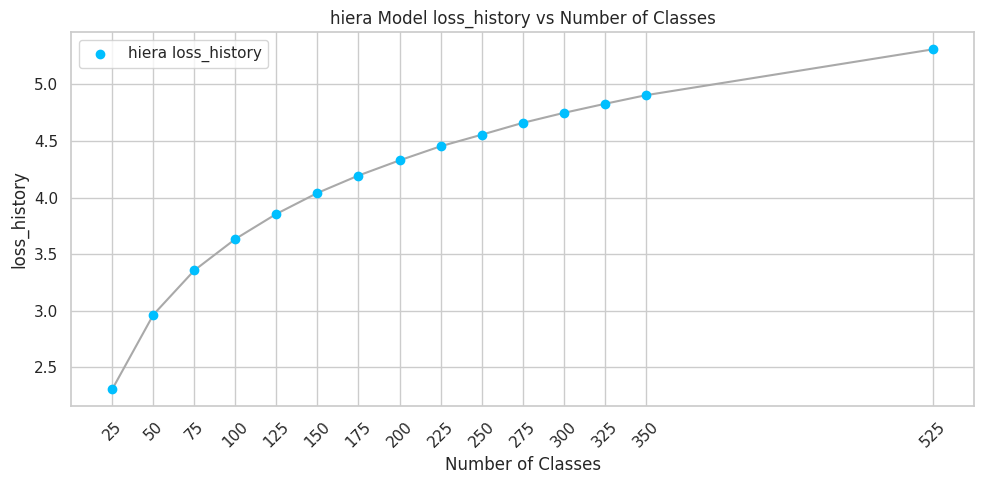

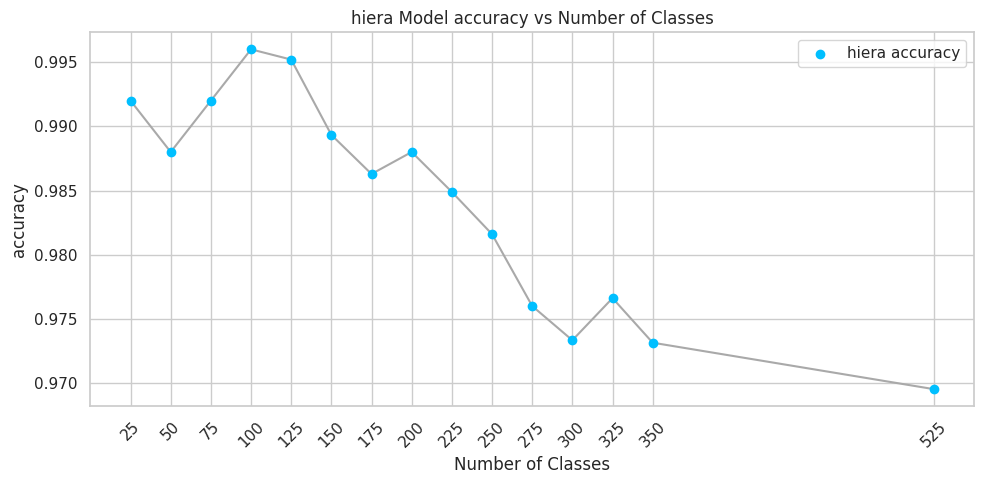

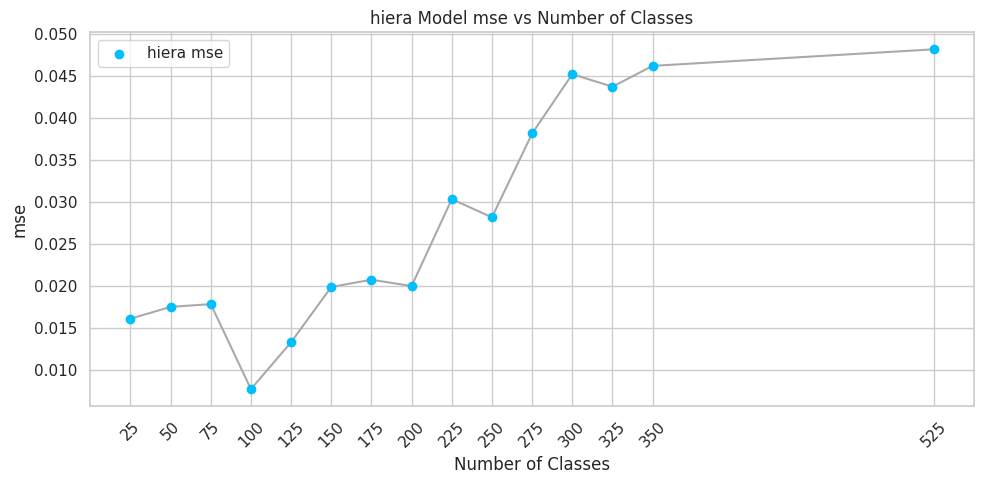

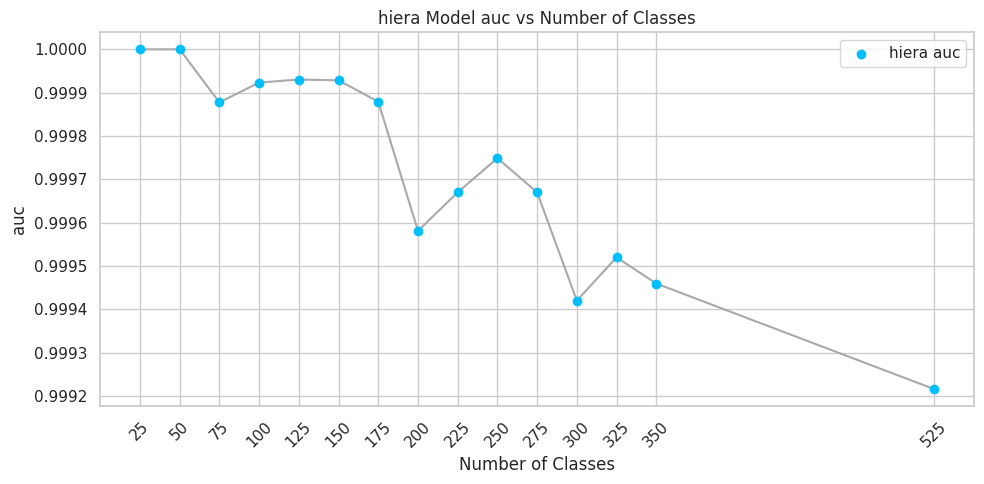

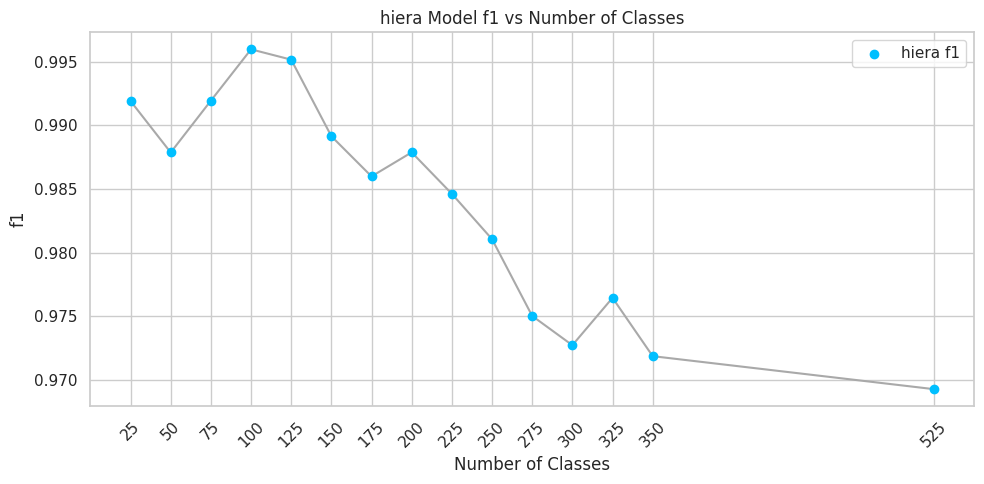

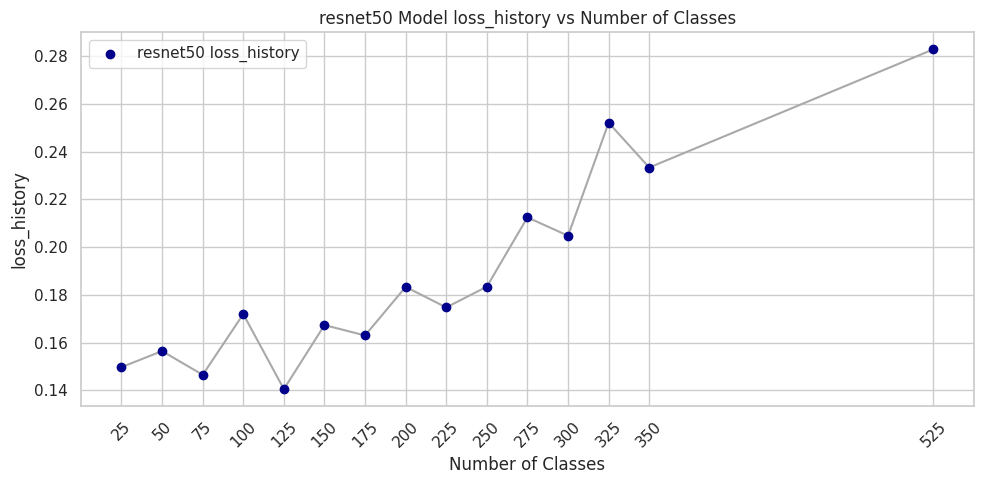

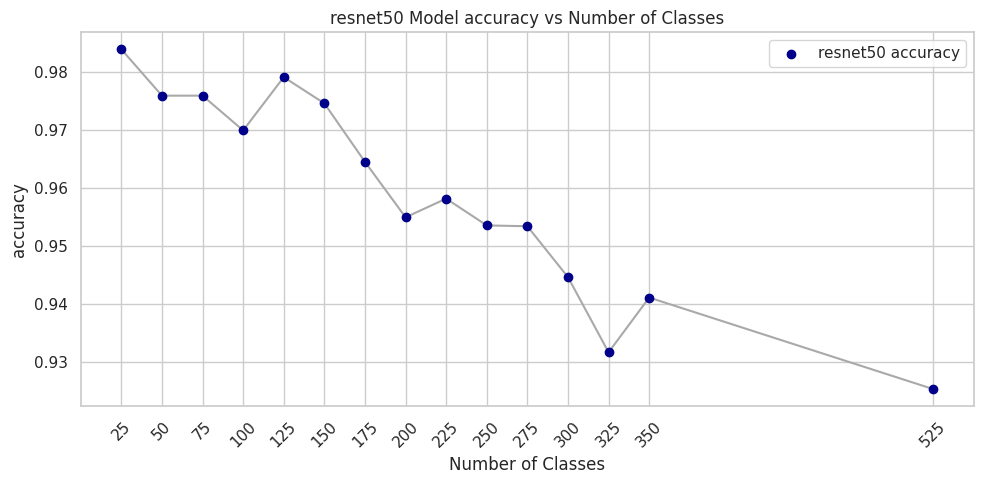

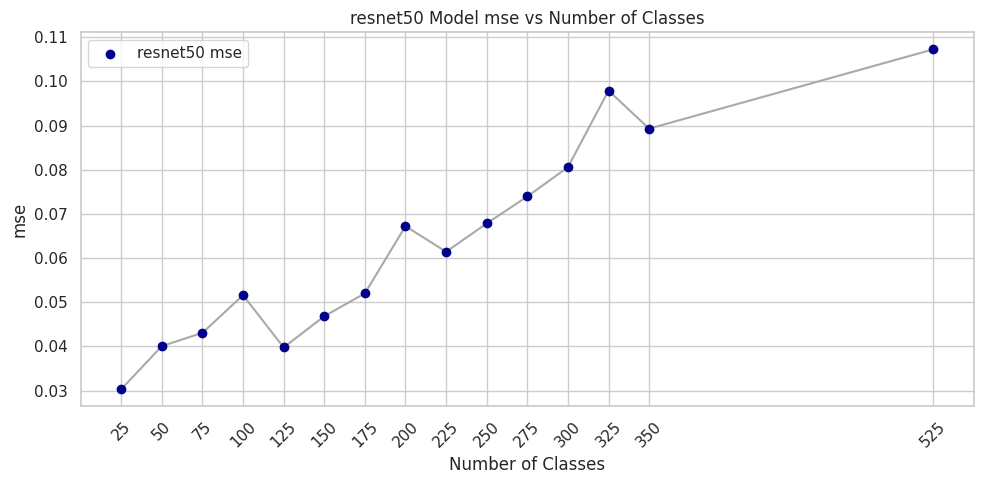

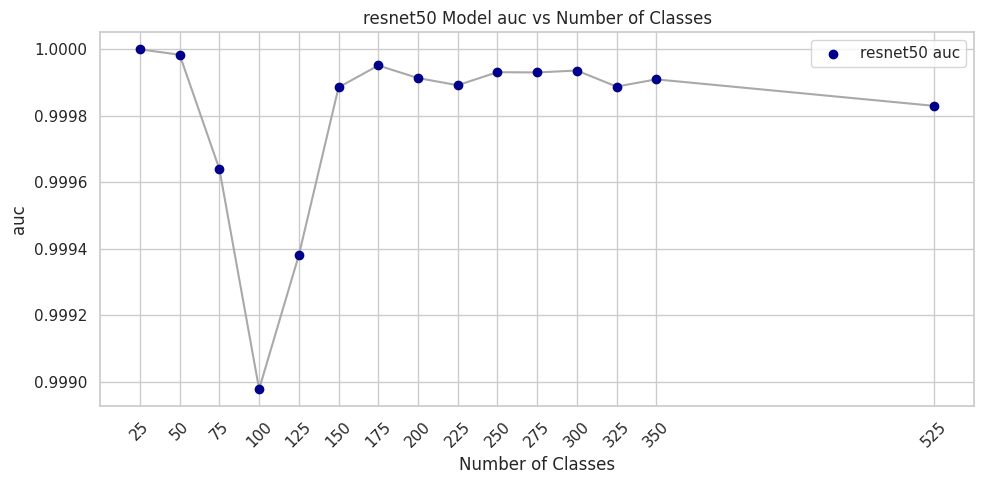

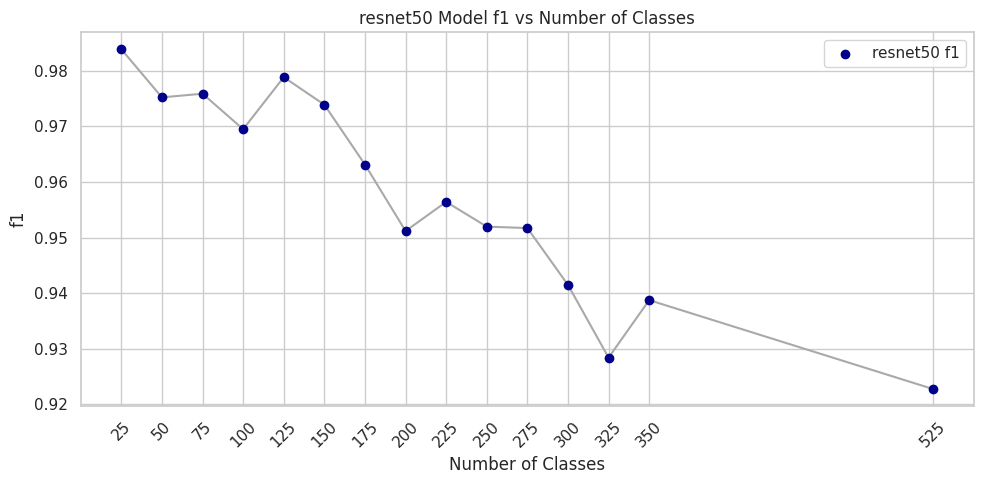

[<matplotlib.collections.PathCollection object at 0x7f757c0b7af0>, <matplotlib.collections.PathCollection object at 0x7f757c48c880>]
['hiera', 'resnet50']


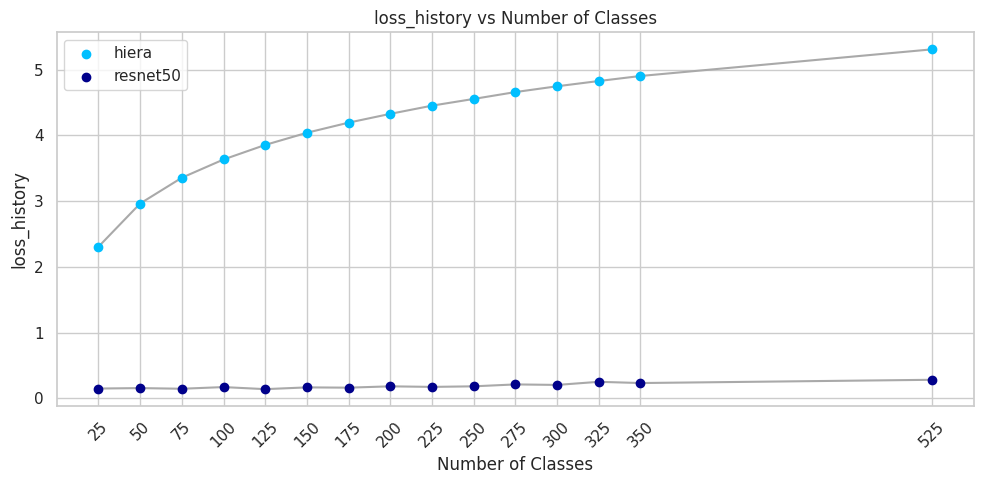

loss_history slope hiera: 0.005550733073323793
loss_history slope resnet: 0.00028981531321641067
[<matplotlib.collections.PathCollection object at 0x7f757c5c7370>, <matplotlib.collections.PathCollection object at 0x7f75ca3757f0>]
['hiera', 'resnet50']


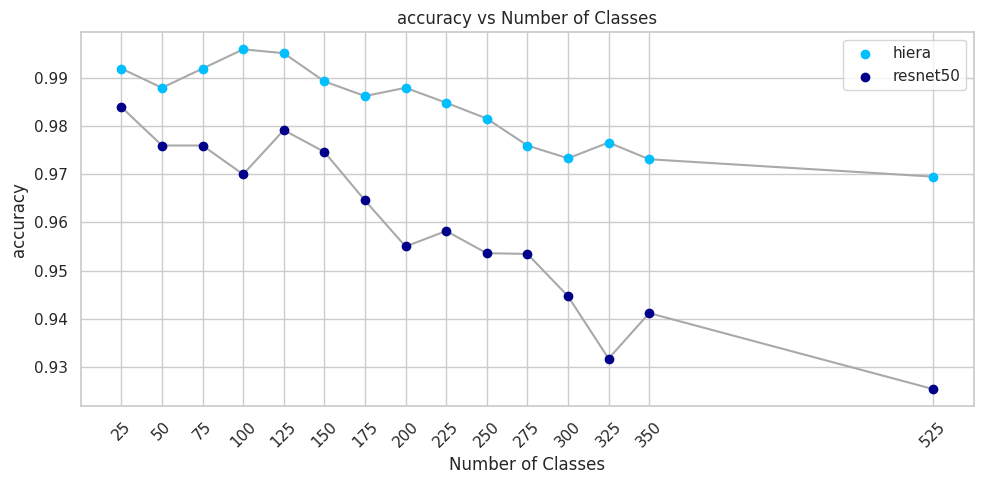

accuracy slope hiera: -5.7963369963369504e-05
accuracy slope resnet: -0.00012790948019116997
[<matplotlib.collections.PathCollection object at 0x7f75d8425e80>, <matplotlib.collections.PathCollection object at 0x7f75ca395d30>]
['hiera', 'resnet50']


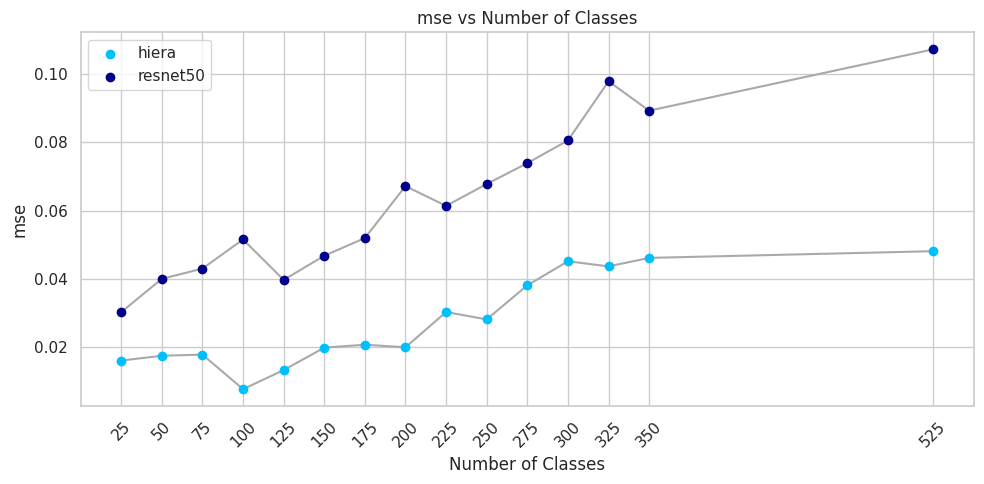

mse slope hiera: 9.046766969291381e-05
mse slope resnet: 0.00016522839253159592
[<matplotlib.collections.PathCollection object at 0x7f757cb44370>, <matplotlib.collections.PathCollection object at 0x7f757deda7c0>]
['hiera', 'resnet50']


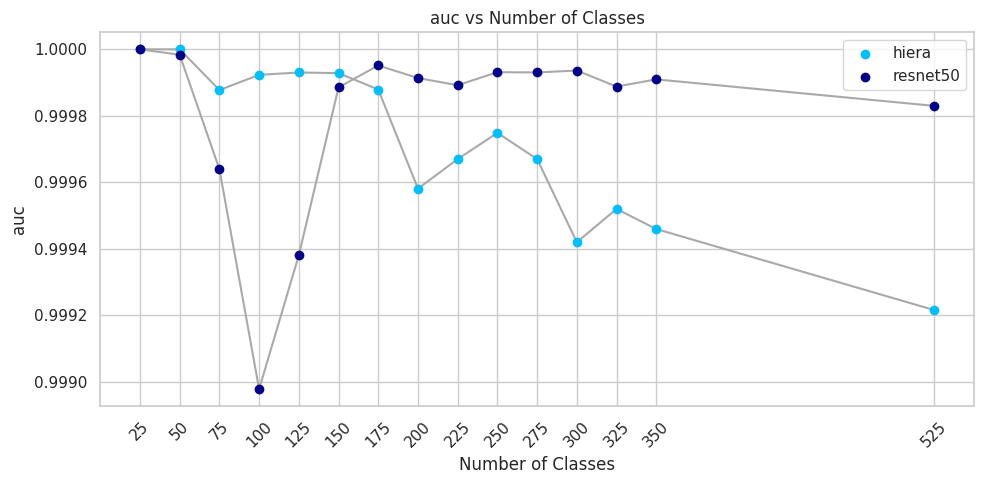

auc slope hiera: -1.7024639144046947e-06
auc slope resnet: 5.313149491007883e-07
[<matplotlib.collections.PathCollection object at 0x7f757d8696d0>, <matplotlib.collections.PathCollection object at 0x7f757d5052e0>]
['hiera', 'resnet50']


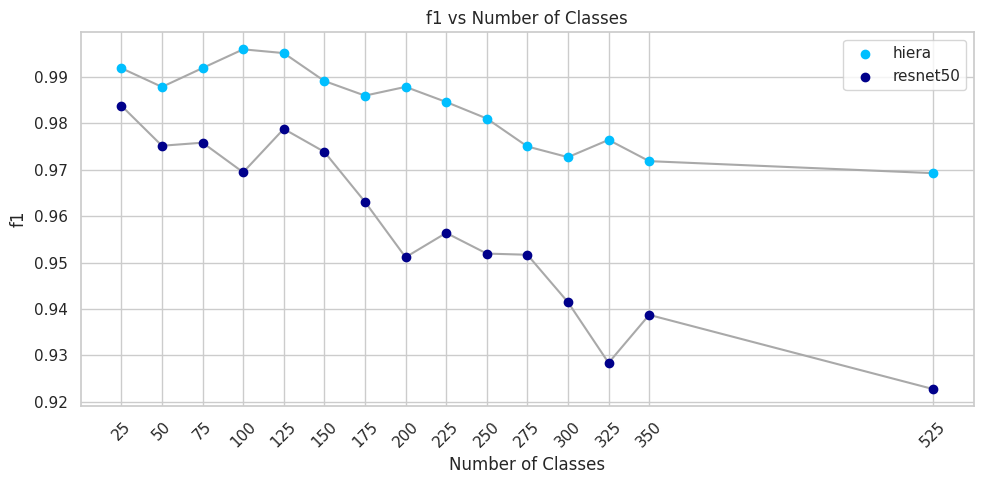

f1 slope hiera: -5.932740335258892e-05
f1 slope resnet: -0.00013441347534787895


In [116]:
metrics_dict['hiera']

# plot all metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os


import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

sns.set(style="whitegrid")

def plot_all_metrics(metrics_dict, metric_name, model_name, frozen, save_path, ci=False):
    plot_metrics = []
    classes = []
    ci_lower = []
    ci_upper = []
    
    metrics = metrics_dict[model_name][metric_name]
    for idx in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20]:
        if type(metrics[idx]) == str:
            continue
        else:
            plot_metrics.append(metrics[idx])
            classes.append(int((idx + 1) * 25))
            if ci:
                ci_lower.append(metrics_dict[model_name]['ci'][idx][0]) 
                ci_upper.append(metrics_dict[model_name]['ci'][idx][1])

    plt.figure(figsize=(10, 5))
    plt.plot(classes, plot_metrics, color='darkgrey', zorder=1)

    # Add a dot for each line in the specified color
    if model_name == 'hiera':
        plt.scatter(classes, plot_metrics,  label=f'{model_name} {metric_name}', color='deepskyblue', zorder=2)
    else:
        plt.scatter(classes, plot_metrics, label=f'{model_name} {metric_name}', color='darkblue', zorder=2)
    plt.xticks(classes, rotation=45)
    
    if ci:
        for idx in range(len(classes)):
            print(f'{plot_metrics[idx]} | diff: {ci_upper[idx] - ci_lower[idx]} | CI: {ci_lower[idx]} - {ci_upper[idx]}')
        # Plot confidence interval with markers
        plt.errorbar(classes, plot_metrics, yerr=[np.array(plot_metrics) - np.array(ci_lower), 
                                              np.array(ci_upper) - np.array(plot_metrics)], 
                 fmt='o', ecolor='g', capthick=2, capsize=5)

    plt.xlabel('Number of Classes')
    plt.ylabel(metric_name)
    plt.title(f'{model_name} Model {metric_name} vs Number of Classes')
    plt.xticks(classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'Results/plots', f'{metric_name}_{model_name}_{frozen}.png'))
    plt.show()



for model_name in ['hiera','resnet50']:
    for metric in ['loss_history','accuracy','mse','auc','f1']:
        plot_all_metrics(metrics_dict,metric,model_name,frozen,PROJECT_FOLDER)

In [ ]:


def plot_all_metrics_both_models(metrics_dict, metric_name, frozen, save_path):
    plot_metrics_hiera = []
    plot_metrics_resnet = []
    classes = []    
    metrics_hiera = metrics_dict['hiera'][metric_name]
    metrics_resnet = metrics_dict['resnet50'][metric_name]
    for idx in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,20]:
        if type(metrics_hiera[idx]) == str:
            continue
        else:
            plot_metrics_hiera.append(metrics_hiera[idx])
            plot_metrics_resnet.append(metrics_resnet[idx])
            classes.append(int((idx+1)*25))
    
    plt.figure(figsize=(10,5))

    # Plot lines in grey
    plt.plot(classes, plot_metrics_hiera, color='darkgrey', zorder=1)
    plt.plot(classes, plot_metrics_resnet,  color='darkgrey', zorder=1)

    # Add a dot for each line in the specified color
    plt.scatter(classes, plot_metrics_hiera, label='hiera', color='deepskyblue', zorder=2)
    plt.scatter(classes, plot_metrics_resnet, label='resnet50', color='darkblue', zorder=2)
    plt.xticks(classes, rotation=45)
    plt.xlabel('Number of Classes')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} vs Number of Classes')
    # Make legend colors scatter colors instead of line colors
    handles, labels = plt.gca().get_legend_handles_labels()
    print(handles), print(labels)
    plt.legend(handles=handles[2:], labels=labels[2:])
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'Results/plots', f'{metric_name}_both_models_{frozen}.png'))
    plt.show()

    # Calculate and print slopes
    slope_hiera = np.polyfit(classes, plot_metrics_hiera, 1)[0]
    slope_resnet = np.polyfit(classes, plot_metrics_resnet, 1)[0]
    print(f'{metric_name} slope hiera: {slope_hiera}')
    print(f'{metric_name} slope resnet: {slope_resnet}')

# Example usage
for metric in ['loss_history', 'accuracy', 'mse', 'auc', 'f1']:
    plot_all_metrics_both_models(metrics_dict, metric, 'Frozen', PROJECT_FOLDER)



In [206]:
slope_hiera= 9.046766969291381e-05
slope_resnet= 0.00016522839253159592

times_higher = abs(slope_resnet) / abs(slope_hiera)
times_higher

1.8263805522177388